In [1]:
import os
os.chdir('../app')

In [2]:
import matplotlib
print(matplotlib.__version__)

3.0.3


In [3]:
import frontend.stock_analytics as salib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime,timedelta
from pprint import pprint
import matplotlib.patches as patches
import time
import numpy as np
import datetime
import copy
import preprocessing.lob.s03_fill_cache as l03
import re
import preprocessing.preglobal as pg
import math
%matplotlib inline
import random
import math
import scipy.optimize
import scipy.optimize
import json
import analysis_lib as al

In [4]:
import scipy.special

In [5]:
import cv2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pymongo import MongoClient, UpdateMany, UpdateOne, InsertOne
import pandas as pd

In [6]:
plt.rcParams['figure.figsize'] = (15, 5)

In [7]:
def binary_search( f, target, cstep=10, stepsize=10, prevturn=True): # mon increasing func
    #print(f(cstep), target, cstep, stepsize)
    if cstep > 1e5:
        return -1
    res = target/f(cstep) 
    if np.abs(res-1) < 1e-4:
        return cstep
    
    if res < 1:  
        stepsize /= 2
        prevturn=False
        cstep -= stepsize 
    else:
        if prevturn:
            stepsize *= 2
        else:
            stepsize /= 2
        cstep += stepsize 
    return binary_search( f, target, cstep, stepsize,prevturn)

In [8]:
# Simulate using inverse transform

In [9]:
# Theoretische Verteilung

def integral_over_phi_slow(t,deltat, omegak, a, K, phi_0,g):
    summand = 0
    
    if len(t) > 0:
        for k in range(0,K):
            summand += (1-np.exp(-omegak[k]*deltat))*np.sum(a[k]*np.exp(-omegak[k]*(t[-1]-t)))

    return deltat*phi_0 + g*summand

def integral_over_phi(t,deltat, omegak, a, K, phi_0,g):
   
    summand = np.sum((1-np.exp(-np.outer(omegak,deltat))).T * np.sum(np.multiply(np.exp(-np.outer(omegak,(t[-1]-t))).T,a), axis=0)  ,axis=1) \
        if len(t) > 0 else 0
    return deltat*phi_0 + g*summand
            
def probability_for_inter_arrival_time(t, deltat, omegak, a, K, phi_0,g):

    x= integral_over_phi(t,deltat, omegak, a, K, phi_0,g)
    return 1-np.exp(-x)
def probability_for_inter_arrival_time_slow(t, deltat, omegak, a, K, phi_0,g):
    x = np.zeros(len(deltat))
    for i in range(0, len(deltat)):
        x[i]= integral_over_phi_slow(t,deltat[i], omegak, a, K, phi_0,g)
    return 1-np.exp(-x)

In [10]:


g_cache_dict = {}


def simulate_by_itrans(phi_dash, g_params, K, conv1=1e-8, conv2=1e-2, N = 250000, init_array=np.array([]), reseed=True, status_update=True, use_binary_search=True):
    # Initialize parameters
    g, g_omega, g_beta = g_params
    
    phi_0 = phi_dash * (1-g)
    
    omegak, a = al.generate_series_parameters(g_omega, g_beta, K)
    

    if reseed:
        np.random.seed(123)
    salib.tic()
    i = randii = 0
    t = 0.
    randpool = np.random.rand(100*N)


    # Inverse transform algorithm
    init_array = np.array(init_array, dtype='double')
    hawkes_array = np.pad(init_array,(0,N-len(init_array)), 'constant', constant_values=0.)   #np.zeros(N)
    hawkes_array = np.array(hawkes_array, dtype='double')
    i = len(init_array)
    if i > 0:
        t = init_array[-1]
        
    endsize = 20
    tau = 0
    while i < N: 
        NN = 10000
        
        u = randpool[randii]
        randii+=1
        if randii >= len(randpool):
            print(i)
        
        
        if use_binary_search:
            f = lambda x: probability_for_inter_arrival_time(hawkes_array[:i],x, omegak, a, K, phi_0, g)
            tau = binary_search( f, u,cstep=max(tau,1e-5), stepsize=max(tau,1e-5))
            if tau == -1:
                return hawkes_array[:i]
        else:
            notok = 1
            while notok>0:
                if notok > 10:
                    NN *= 2
                    notok = 1
                tau_x = np.linspace(0,endsize,NN)
                pt = probability_for_inter_arrival_time      (hawkes_array[:i],tau_x, omegak, a, K, phi_0, g)

                okok = True
                if pt[-1]-pt[-2] > conv1:
                    if status_update:
                        print('warning, pt does not converge',i,pt[1]-pt[0],pt[-1]-pt[-2])
                    endsize*=1.1
                    notok += 1
                    okok = False
                if pt[1]-pt[0] > conv2:
                    if status_update:
                        print('warning pt increases to fast',i,pt[1]-pt[0],pt[-1]-pt[-2])
                    endsize/=1.1
                    notok +=1
                    okok = False
                if okok:
                    notok = 0

            tt = np.max(np.where(pt < u))
            if tt == NN-1:
                if status_update:
                    print('vorzeitig abgebrochen', u, tau_x[tt], pt[tt])
                return hawkes_array[:i]
            tau = tau_x[tt] 
        
        t += tau
        
        hawkes_array[i] = t
        i += 1
        if status_update and i%(int(N/5))==0:
            print(i)
            salib.toc()
    if status_update:
        salib.toc()        
    return hawkes_array

In [11]:
# SIMULATION USING THINNING

In [12]:
def calc_eff_g(number_of_events, g):
    noe_binned_x, noe_binned_y, _ = al.dobins(number_of_events, useinteger=True, N=1000) 
    noe_binned_y /= noe_binned_y.sum()
    assert np.abs(np.sum(noe_binned_y) - 1) < 1e-8

    print((noe_binned_x*noe_binned_y).sum(), 'should be', 1/(1-g))

    plt.plot(np.log(noe_binned_x),noe_binned_y)

In [14]:
# noe_thin_no_cache_K15


gg = 0.886205
noe_thin_no_cache_K15 = [len(\
                    simulate_by_thinning(phi_dash=0, g_params=(gg, 0.430042, 0.3),\
                    K=15, N=1000, reseed=False, status_update=False, caching=False, init_array=np.array([0.]))\
                               ) for i in range(0,10000)]

In [15]:
# noe_thin_cache_K15


gg = 0.886205
noe_thin_cache_K15 = [len(\
                    simulate_by_thinning(phi_dash=0, g_params=(gg, 0.430042, 0.3),\
                    K=15, N=1000, reseed=False, status_update=False, caching=True, init_array=np.array([0.]))\
                               ) for i in range(0,10000)]

In [16]:
# noe_itrans_binary_K15


gg = 0.886205
noe_itrans_binary_K15 = [len(\
                    simulate_by_itrans(phi_dash=0, g_params=(gg, 0.430042, 0.3),\
                    K=15, N=1000, reseed=False, status_update=False,use_binary_search=True, init_array=np.array([0.]))\
                               ) for i in range(0,10000)]

In [17]:
# noe_itrans_no_binary_K15


gg = 0.886205
noe_itrans_no_binary_K15 = [len(\
                    simulate_by_itrans(phi_dash=0, g_params=(gg, 0.430042, 0.3),\
                    K=15, N=1000, reseed=False, status_update=False, use_binary_search=False, init_array=np.array([0.])
                                      , conv1=1e-5, conv2=1e-2  
                                      )\
                               ) for i in range(0,10000)]

In [18]:
#noe_thin_cache_K0


gg = 0.886205
noe_thin_cache_K0 = [len(\
                    simulate_by_thinning(phi_dash=0, g_params=(gg, 2.430042, 0.),\
                    K=1, N=1000, reseed=False, status_update=False, caching=True, init_array=np.array([0.]))\
                               ) for i in range(0,10000)] # braucht recht lang, weil der cache jedes mal neu aufgebaut wird

In [19]:
# noe_thin_no_cache_K0


gg = 0.886205
noe_thin_no_cache_K0 = [len(\
                    simulate_by_thinning(phi_dash=0, g_params=(gg, 2.430042, 0.),\
                    K=1, N=1000, reseed=False, status_update=False, caching=False, init_array=np.array([0.]))\
                               ) for i in range(0,10000)]

In [20]:
# noe_itrans_binary_K0


gg = 0.886205
noe_itrans_binary_K0 = [len(\
                    simulate_by_itrans(phi_dash=0, g_params=(gg, 2.430042, 0.),\
                    K=1, N=1000, reseed=False, use_binary_search=True, status_update=False,  init_array=np.array([0.]))\
                               ) for i in range(0,10000)]

In [21]:
# noe_itrans_no_binary_K0


gg = 0.886205
noe_itrans_no_binary_K0 = [len(\
                    simulate_by_itrans(phi_dash=0, g_params=(gg, 2.430042, 0.),\
                    K=1, N=1000, reseed=False, use_binary_search=False, status_update=False, init_array=np.array([0.]))\
                             ) for i in range(0,10000)]

1.78 should be 8.787732325673362
8.811 should be 8.787732325673362
6.3285 should be 8.787732325673362
8.5301 should be 8.787732325673362
7.437400000000001 should be 8.787732325673362
2.6673 should be 8.787732325673362
8.5415 should be 8.787732325673362
8.6242 should be 8.787732325673362


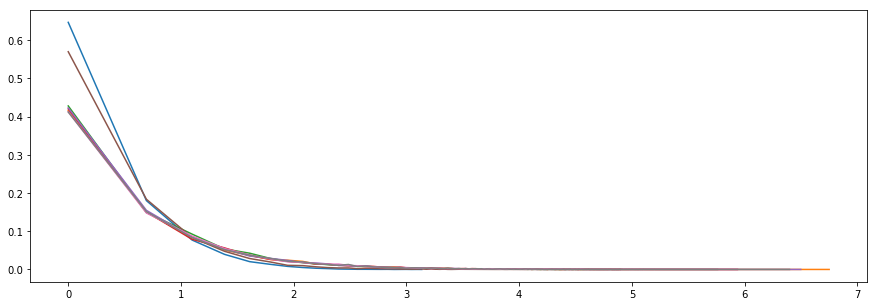

In [42]:
calc_eff_g(noe_thin_cache_K15,gg)
calc_eff_g(noe_thin_no_cache_K15,gg)
calc_eff_g(noe_thin_cache_K0,gg)
calc_eff_g(noe_thin_no_cache_K0,gg)

calc_eff_g(noe_itrans_binary_K15,gg)
calc_eff_g(noe_itrans_no_binary_K15,gg)
calc_eff_g(noe_itrans_binary_K0,gg)
calc_eff_g(noe_itrans_no_binary_K0,gg)

In [43]:
eff_g_sim = {
    'noe_thin_cache_K15':noe_thin_cache_K15,
    'noe_thin_no_cache_K15':noe_thin_no_cache_K15,
    'noe_thin_cache_K0':noe_thin_cache_K0,
    'noe_thin_no_cache_K0':noe_thin_no_cache_K0,
    'noe_itrans_binary_K15':noe_itrans_binary_K15,
    'noe_itrans_no_binary_K15':noe_itrans_no_binary_K15,
    'noe_itrans_binary_K0':noe_itrans_binary_K0,
    'noe_itrans_no_binary_K0':noe_itrans_no_binary_K0
    
}

In [47]:
with open('eff_g_sim.json','w') as f:
    json.dump( eff_g_sim, f)

In [48]:
gg

0.886205

In [23]:
sim_thin_no_cache = simulate_by_thinning(phi_dash=68, g_params=(0.886205, 0.430042, 0.253835),  K=15, N=10000, caching=False)

2000 0
Elapsed time: 1.0960224450100213s
4000 0
Elapsed time: 3.1059566409967374s
6000 0
Elapsed time: 5.171833390981192s
8000 0
Elapsed time: 7.224790724023478s
10000 0
Elapsed time: 8.575880032003624s
Elapsed time: 3.456699778325856e-05s


In [24]:
sim_thin_cache = simulate_by_thinning(phi_dash=68, g_params=(0.886205, 0.430042, 0.253835),  K=15, N=10000, caching=True)

2000 1886
Elapsed time: 0.04711742399376817s
4000 3897
Elapsed time: 0.030598042998462915s
6000 5901
Elapsed time: 0.047899760014843196s
8000 7901
Elapsed time: 0.03123947200947441s
10000 9916
Elapsed time: 0.030695025983732194s
Elapsed time: 3.0800001695752144e-05s


In [25]:
sim_itrans_binary = simulate_by_itrans(phi_dash=68, g_params=(0.886205, 0.430042, 0.253835),  use_binary_search=True, K=15, N=10000, reseed=False)


2000
Elapsed time: 7.0840122230001725s
4000
Elapsed time: 20.246189875993878s
6000
Elapsed time: 33.406934698985424s
8000
Elapsed time: 46.55770056502661s
10000
Elapsed time: 56.10909874597564s
Elapsed time: 3.578801988624036e-05s


In [26]:
sim_itrans_nobinary = simulate_by_itrans(phi_dash=68, g_params=(0.886205, 0.430042, 0.253835),  use_binary_search=False, K=15, N=10000, reseed=False)


warning pt increases to fast 0 0.015358504250275185 0.0
warning pt increases to fast 0 0.013972078728341608 0.0
warning pt increases to fast 0 0.012709997941108275 0.0
warning pt increases to fast 0 0.011561250015658886 0.0
warning pt increases to fast 0 0.010515773892402658 0.0
warning pt increases to fast 3 0.010091790995619854 0.0
warning pt increases to fast 10 0.010027778094763073 0.0
warning pt increases to fast 24 0.010023764377014244 0.0
warning pt increases to fast 49 0.010071263274003428 0.0
warning pt increases to fast 67 0.01000621959399317 0.0
warning pt increases to fast 136 0.010033805989875688 0.0
warning pt increases to fast 180 0.010070587153679589 0.0
warning pt increases to fast 348 0.010001676862528064 0.0
warning pt increases to fast 482 0.010004380232067067 0.0
warning pt increases to fast 1014 0.010003682334964625 0.0
2000
Elapsed time: 5.6913907320122235s
warning pt increases to fast 2008 0.01002500617405122 0.0
warning pt increases to fast 2780 0.0100200953521

In [50]:
import importlib

In [51]:
importlib.reload(al)

<module 'analysis_lib' from '/home/jovyan/MasterThesis/MasterThesis/analysis/analysis_lib.py'>

In [64]:
import task_lib as tl

In [67]:
with open('17_simulation.json', 'w') as f:
    json.dump([ ('sim_thin_no_cache',sim_thin_no_cache), 
                ('sim_itrans_binary',sim_itrans_binary),
                ('sim_itrans_nobinary',sim_itrans_nobinary)],f, cls=tl.NumpyEncoder)

V = 13.044999 ; E = 9.999 ; V/E = 1.3046303630363036
V = 13.574 ; E = 10.0 ; V/E = 1.3574
V = 13.56 ; E = 10.0 ; V/E = 1.356


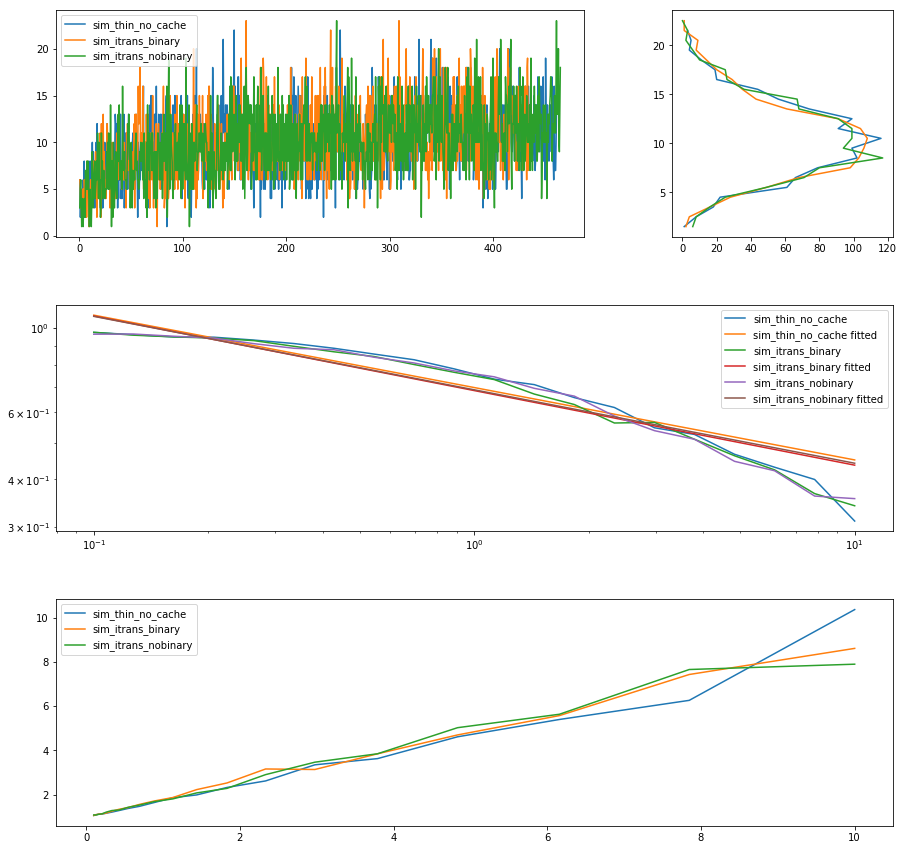

In [61]:
al.print_stats([ ('sim_thin_no_cache',sim_thin_no_cache), 
               
                ('sim_itrans_binary',sim_itrans_binary),
                ('sim_itrans_nobinary',sim_itrans_nobinary)],
               tau = np.logspace(-1,1,20), stepsize_hist=1.)

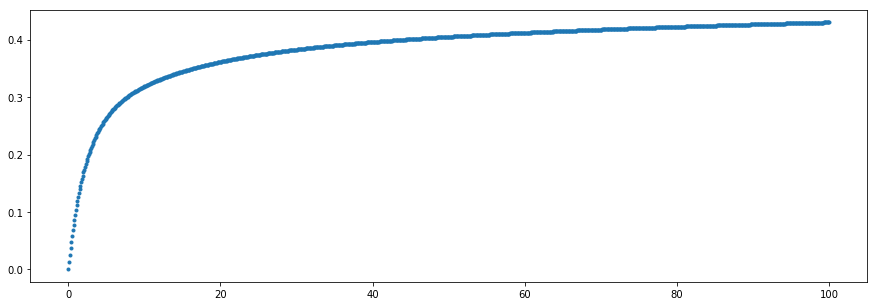

In [39]:
# Show probability distribution!

tg, tg_omega, tg_beta = (0.786205, 0.430042, 0.253835)
tK = 15
tphi_0 = 0
tomegak, ta = al.generate_series_parameters(tg_omega, tg_beta, K=tK, b=5.)


thawkes_array = np.zeros(10)
thawkes_array[0] = 0
ti = 1
tj = 0


tau_x = np.linspace(0.,100,1000)
pt = probability_for_inter_arrival_time(thawkes_array[tj:ti],tau_x,  tomegak, ta, tK, tphi_0, tg)

plt.plot(tau_x,pt,'.')

In [40]:
# TEST IF BOTH ARE THE SAME
tt = np.array([0.01388255])
tdeltat = np.linspace(0,1.2607881726256949,1000)
tomegak = np.array([0.430042, 0.0006565823727274271, 1.0024611832713502e-06, 1.5305443242275112e-09, 2.3368145994246977e-12, 3.567817269741932e-15, 5.447295679084947e-18, 8.31685817180986e-21, 1.2698067798225314e-23, 1.9387240046350152e-26, 2.960017875060756e-29, 4.519315694101945e-32, 6.900030744759242e-35, 1.053487463616628e-37, 1.6084505664563106e-40])
ta = np.array([0.8071834195758446, 0.15563834675047422, 0.030009653805760286, 0.005786358827014711, 0.0011157059222237438, 0.0002151266006998307, 4.1479975508621093e-05, 7.998027034306966e-06, 1.5421522230216854e-06, 2.973525181609743e-07, 5.733449573701989e-08, 1.1055041409263513e-08, 2.1315952811567083e-09, 4.110069129946613e-10, 7.924894750082819e-11])
tK = 15
tphi_0 = 7.738059999999999
tg = 0.886205

assert (np.abs(probability_for_inter_arrival_time_slow(tt, tdeltat, tomegak, ta, tK, tphi_0, tg) - probability_for_inter_arrival_time(tt, tdeltat, tomegak, ta, tK, tphi_0, tg)) < 1e-10).all()